In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import statsmodels.api as sm

import utils

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
bids = np.load('data/raw/06-23/bid-record.npy')
asks = np.load('data/raw/06-23/ask-record.npy')
times = np.array(list(map(np.datetime64, map(datetime.fromtimestamp, np.load('data/raw/06-23/time-record.npy')))))
print(bids.shape)

(200000, 256, 2)


In [3]:
def construct_df(agg_sz=1, roll_mean_window_size=20):
    """agg_sz is in USD
    roll_mean_window_size is integer size for window"""

    agg_bid_vol = utils.get_aggregate_volume(bids, is_bid=True, agg_sz=agg_sz)
    agg_ask_vol = utils.get_aggregate_volume(asks, is_bid=False, agg_sz=agg_sz)
    agg_oir = (agg_bid_vol - agg_ask_vol) / (agg_bid_vol + agg_ask_vol)

    df = pd.DataFrame(data={'bid': bids[:, -1, 0],
                            'ask': asks[:, 0, 0],
                            'bid-volume': agg_bid_vol,
                            'ask-volume': agg_ask_vol,
                            'mid': (bids[:, -1, 0] + asks[:, 0, 0]) / 2,
                            'oir': agg_oir,
                            'time': times})

    df['dmid'] = df['mid'] - df['mid'].shift(1)
    df['oi'] = utils.get_oi(df)

    df['roll-mid'] = df['mid'].rolling(roll_mean_window_size).mean()
    
    return df

def gen_graphs(df):
    plt.figure(figsize=(30,20))

    height = 4

    plt.subplot(height, 2, 1)
    plt.plot(df['dmid'][0:1000]), plt.title('dmid')
    plt.subplot(height, 2, 2)
    lags = np.arange(30) + 1
    plt.bar(lags, [df['dmid'].autocorr(lag=lag) for lag in lags]), plt.title('dmid-autocorr')

    plt.subplot(height, 2, 3)
    plt.plot(df['oir'][0:1000]), plt.title('oir')
    plt.subplot(height, 2, 4)
    lags = np.arange(30) + 1
    plt.bar(lags, [df['oir'].autocorr(lag=lag) for lag in lags]), plt.title('oir-autocorr')

    plt.subplot(height, 2, 5)
    plt.plot(df['oi'][0:300]), plt.title('oi')
    plt.subplot(height, 2, 6)
    lags = np.arange(30) + 1
    plt.bar(lags, [df['oi'].autocorr(lag=lag) for lag in lags]), plt.title('oi-autocorr')

    plt.subplot(height, 2, 7)
    lags = np.arange(30) + 1
    plt.bar(lags, [df['oi'].corr(df['dmid'].shift(lag)) for lag in lags]), plt.title('oi-dmid-corr')
    plt.subplot(height, 2, 8)
    lags = np.arange(30) + 1
    plt.bar(lags, [df['oir'].corr(df['dmid'].shift(lag)) for lag in lags]), plt.title('voi-dmid-corr')

CPU times: user 3.28 s, sys: 2.52 s, total: 5.8 s
Wall time: 5.98 s


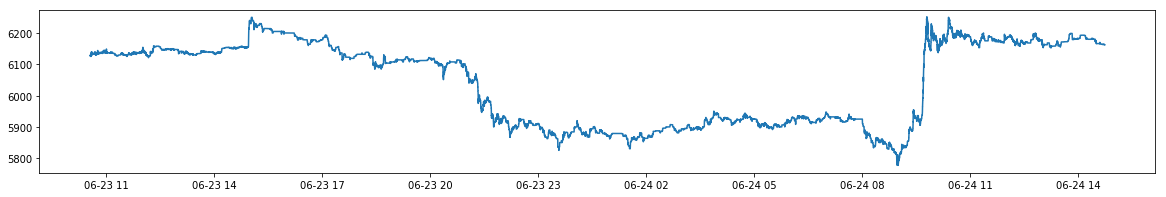

In [4]:
%%time
# construct_df(1, 20).to_pickle('data/dfs/06-19.pkl')
plt.figure(figsize=(20,3))
plt.plot_date(times, construct_df(agg_sz=1, roll_mean_window_size=20)['mid'], fmt='-')
construct_df(agg_sz=1, roll_mean_window_size=20)[0:3]

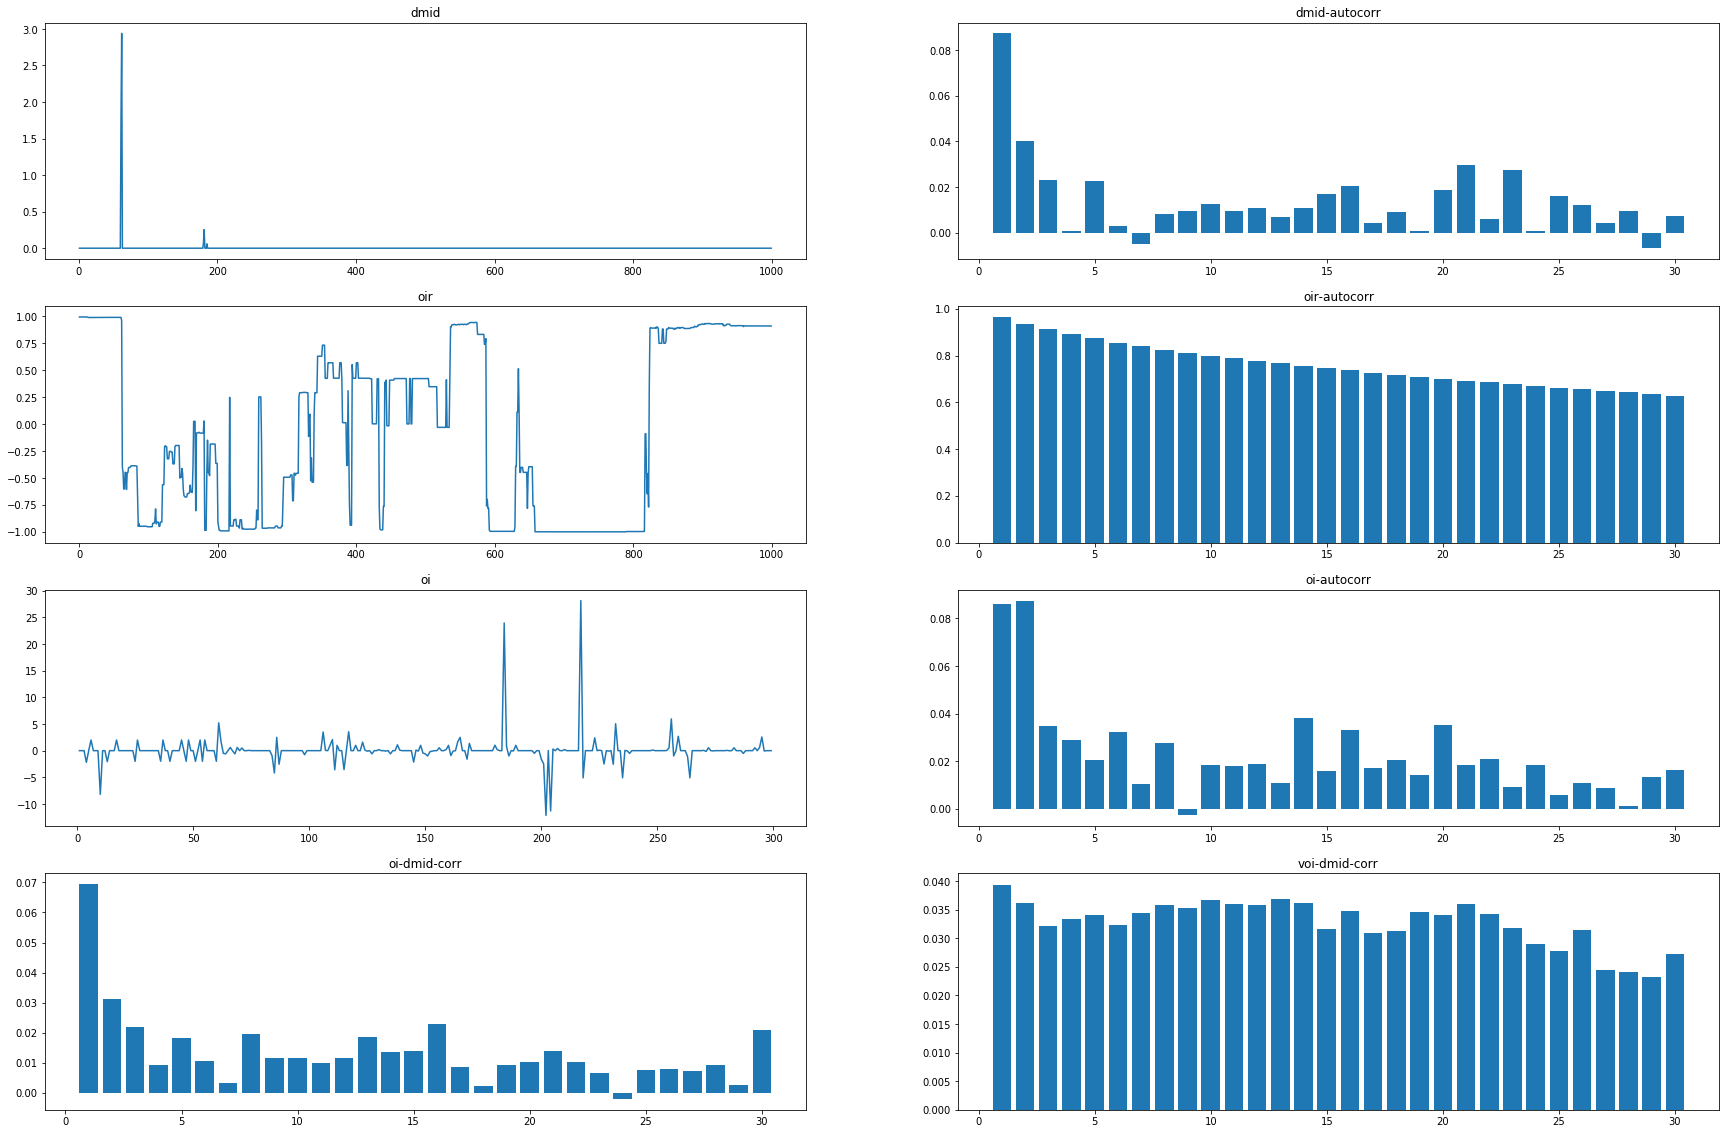

In [6]:
gen_graphs(construct_df(agg_sz=1, roll_mean_window_size=20))

In [11]:
def fit(agg_sz=1, roll_mean_window_size=20, oi_features=5):
    """oi_features: how many timesteps back do we use OI"""

    df = construct_df(agg_sz=agg_sz, roll_mean_window_size=roll_mean_window_size)
    
    y = df['roll-mid'].shift(-roll_mean_window_size) - df['mid']
    y = y.round(decimals=8) # make things close to zero (floating point error) actually zero

    X = np.zeros((df.shape[0], oi_features))
    for i in range(oi_features):
        X[:, i] = df['oi'].shift(i).values

    model = sm.OLS(y, sm.add_constant(X), missing = 'drop')
    results = model.fit()
    return results

fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     192.6
Date:                Sun, 24 Jun 2018   Prob (F-statistic):          1.82e-203
Time:                        18:10:13   Log-Likelihood:                -50973.
No. Observations:               39975   AIC:                         1.020e+05
Df Residuals:                   39969   BIC:                         1.020e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0338      0.004      7.803      0.000       0.025       0.042
x1             0.0113      0.001     18.592      0.000       0.010       0.013
x2             0.0080      0.001     13.031      0.000       0.007       0.009
x3             0.0060      0.001      9.827      0.000       0.005       0.007
x4             0.0053      0.001      8.679      0.000       0.004       0.007
x5             0.0054      0.001      8.870      0.000       0.004       0.007
==============================================================================
Omnibus:                    37742.081   Durbin-Watson:                   0.129
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10425107.475
Skew:                           3.916   Prob(JB):                         0.00
Kurtosis:                      81.725   Cond. No.                         8.08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""